In [25]:
!pip install graphdatascience scikit-multilearn==0.2.0 scikit-learn==1.2.1 wordcloud==1.8.2.2 seaborn==0.12.2

     |████████████████████████████████| 9.8 MB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 293 kB 35.1 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 34.0 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
      Successfully uninstalled seaborn-0.11.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.1
    Uninstalling scikit-learn-1.1.1:
      Successfully uninstalled scikit-learn-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
karateclub 1.2.0 requires decorator==4.4.2, but you have decorator 5.0.5 which is incompatible.
classy-core 0.2.1 requires datasets=

In [34]:
import numpy as np
import pandas as pd

from graphdatascience import GraphDataScience

from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.problem_transform import LabelPowerset

from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_colwidth", 100)
sns.set(rc={"figure.figsize": (16, 9)})

In [41]:
host = "bolt://localhost:7687"
user = "neo4j"
password = "pleaseletmein"

gds = GraphDataScience(host, auth=(user, password))

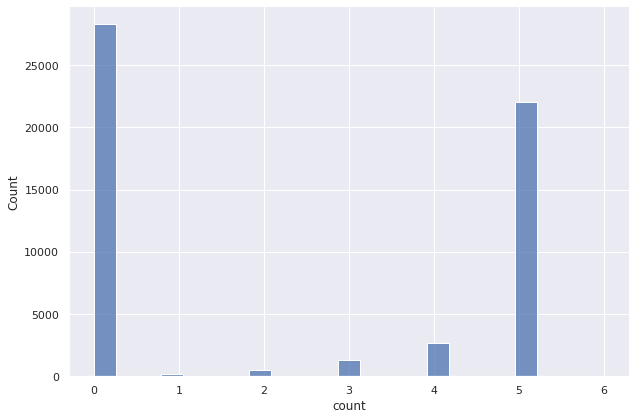

In [35]:
dist_df = gds.run_cypher("""
MATCH (a:Article)
RETURN count{(a)-[:HAS_TAG]->()} AS count
""")

sns.displot(dist_df['count'], height=6, aspect=1.5)

In [21]:
gds.run_cypher(
    """
MATCH (a:Article)
RETURN exists {(a)-[:IN_LIST]-()} AS in_list,
       count(*) AS count
ORDER BY count DESC
"""
)

,in_list,count
0,True,54932


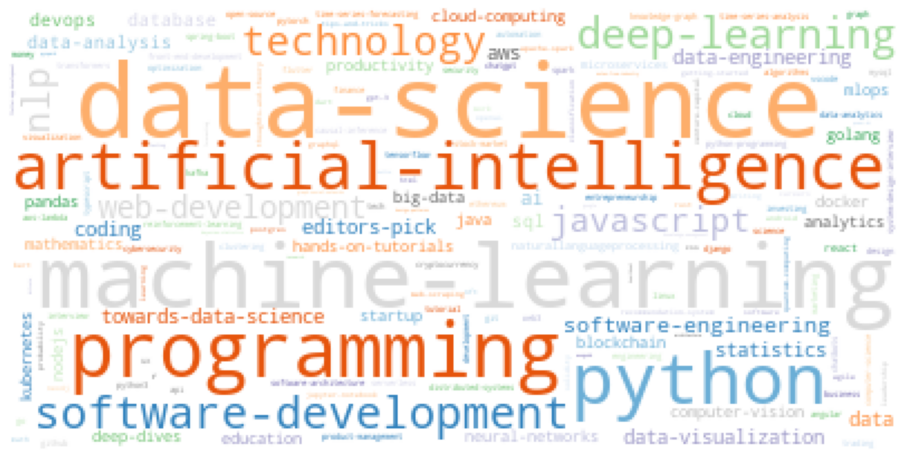

In [39]:
tags = gds.run_cypher(
    """
MATCH (t:Tag)
WITH t, count {(t)<--()} AS size
WHERE size > 100
RETURN t.name AS tag, size
ORDER BY size DESC
"""
)

d = {}
for i, row in tags.iterrows():
    d[row["tag"]] = row["size"]

wordcloud = WordCloud(
    background_color="white", colormap="tab20c", min_font_size=1
).generate_from_frequencies(d)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [9]:
G, metadata = gds.graph.project(
    "articles", ["Article", "List"], "IN_LIST", nodeProperties=["openaiEmbedding"]
)

In [10]:
gds.nodeSimilarity.mutate(
    G, topK=2000, mutateProperty="score", mutateRelationshipType="SIMILAR"
)

NodeSimilarity:   0%|          | 0/100 [00:00<?, ?%/s]

preProcessingMillis                                                                                                         0
computeMillis                                                                                                           28909
mutateMillis                                                                                                             1532
postProcessingMillis                                                                                                       -1
nodesCompared                                                                                                           54933
relationshipsWritten                                                                                                 12576142
similarityDistribution    {'p1': 0.05263155698776245, 'max': 1.0000075697898865, 'p5': 0.08333343267440796, 'p90': 1.00000...
configuration             {'topK': 2000, 'similarityMetric': 'JACCARD', 'bottomK': 10, 'bottomN': 0, 'mutateRelationsh

In [11]:
wcc = gds.wcc.stream(G)

In [12]:
wcc_grouped = (
    wcc.groupby("componentId")
    .size()
    .to_frame("componentSize")
    .reset_index()
    .sort_values("componentSize", ascending=False)
    .reset_index()
)
wcc_grouped

,index,componentId,componentSize
0,1,20,54802
1,7,149,368
2,4,124,193
3,23,374,134
4,16,288,117
...,...,...,...
599,493,25649,2
600,475,23247,2
601,490,25232,2
602,372,14429,2


In [13]:
largest_component = wcc_grouped["componentId"][0]
start_node = wcc[wcc["componentId"] == largest_component]["nodeId"][0]

In [14]:
trainG, metadata = gds.alpha.graph.sample.rwr(
    "trainGraph",
    G,
    samplingRatio=0.20,
    startNodes=[int(start_node)],
    nodeLabels=["Article"],
    relationshipTypes=["SIMILAR"],
)

In [15]:
%%time
gds.beta.graphSage.train(
    trainG,
    modelName="articleModel",
    embeddingDimension=256,
    sampleSizes=[10, 10],
    searchDepth=15,
    epochs=20,
    learningRate=0.0001,
    activationFunction="RELU",
    aggregator="MEAN",
    featureProperties=["openaiEmbedding"],
    batchSize=10,
)

CPU times: total: 15.6 ms
Wall time: 1min 19s


(GraphSageModel({'modelInfo': {0: {'modelName': 'articleModel', 'modelType': 'graphSage', 'metrics': {'ranIterationsPerEpoch': [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10], 'iterationLossesPerEpoch': [[26.26019890709872, 26.156118405129234, 26.006712545147508, 25.92684456378698, 25.575018540458483, 25.233838042043317, 25.067721677112406, 24.454238545866506, 24.130776361866218, 23.855447812576283], [22.88812883665899, 22.75306774219593, 22.05075688451951, 21.10843748023248, 20.731906072992217, 21.216923921795864, 20.59486753203335, 20.130998986574916, 19.185815405419945, 19.06932537041294], [18.511604223926863, 19.522669734079425, 18.400375298259693, 19.387847961155238, 18.237012133466642, 18.219625528092546, 17.353690309428497, 17.699450553469205, 17.83412123059852, 18.179846293207596], [17.120774782891676, 17.4705243547433, 17.662944284253353, 17.257237159855592, 16.84714168164934, 17.14394921485289, 16.61470931223102, 17.109660609480617, 17.6142637

In [16]:
gds.beta.graphSage.write(
    G,
    modelName="articleModel",
    nodeLabels=["Article"],
    writeProperty="graphSAGE",
    relationshipTypes=["SIMILAR"],
)

GraphSage:   0%|          | 0/100 [00:00<?, ?%/s]

nodeCount                                                                                                              54933
nodePropertiesWritten                                                                                                  54933
preProcessingMillis                                                                                                        0
computeMillis                                                                                                          70129
writeMillis                                                                                                             2473
configuration            {'jobId': '1417c839-6841-49d3-a09f-9d18440c28bc', 'modelName': 'articleModel', 'writeConcurrency...
Name: 0, dtype: object

In [17]:
trainG.drop()
G.drop()

graphName                                                                                                           articles
database                                                                                                               neo4j
memoryUsage                                                                                                                 
sizeInBytes                                                                                                               -1
nodeCount                                                                                                              59304
relationshipCount                                                                                                   12663437
configuration                                                                                                             {}
density                                                                                                             0.003601


In [56]:
# Tag relevant tags
gds.run_cypher(
    """
MATCH (t:Tag)
WHERE count{(t)<--()} > 100
SET t:Target
RETURN count(*) AS count
"""
)

,count
0,161


In [19]:
data = gds.run_cypher(
    """
MATCH (a:Article)-[:HAS_TAG]->(tag:Target)
RETURN a.url AS article,
        a.openaiEmbedding AS openai,
        a.graphSAGE AS graphSAGE,
        collect(tag.name) AS tags
"""
)

In [20]:
# instantiating MultiLabelBinarizer
mlb = MultiLabelBinarizer()
tags_mlb = mlb.fit_transform(data["tags"])
data["target"] = list(tags_mlb)
data.head()

,article,openai,graphSAGE,tags,target
0,https://medium.com/better-programming/this-python-library-can-animate-your-charts-a7c0a98b3463,"[-0.003536871401593089, 0.00747159868478775, 0.01575239561498165, -0.01385077927261591, 0.005306...","[-0.00216827201804098, -0.009227111265948742, -0.00563064581559813, -0.00014508171659661682, -0....","[machine-learning, data-science, technology, artificial-intelligence, programming]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,https://medium.com/datadriveninvestor/list-of-chatgpt-prompts-for-nlp-practitioners-and-nlp-prod...,"[-0.01077286060899496, -0.0017891748575493693, 0.0182870514690876, -0.013639666140079498, 0.0061...","[0.06765478047581976, -0.006385367097393763, 0.31402097615886226, 0.24863385494108853, -0.000759...","[machine-learning, data-science, deep-learning, python, naturallanguageprocessing]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,https://medium.com/towards-artificial-intelligence/deepminds-clever-idea-to-master-asymmetric-ga...,"[-0.032979629933834076, -0.012398408725857735, 0.022878754884004593, -0.007013346068561077, 0.01...","[-0.002605539977979088, -0.020458296714779865, -0.00022884160487677324, 0.12617565641394737, -0....","[machine-learning, data-science, deep-learning, artificial-intelligence]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,https://medium.com/towards-data-science/must-read-papers-on-gans-b665bbae3317,"[-0.03457323834300041, 0.005550392437726259, 0.028737546876072884, -0.011742711067199707, 0.0239...","[-0.0061481817164827784, -0.009083868650183164, 0.30895234399375493, -0.0013392862736176779, -0....","[machine-learning, data-science, deep-learning, artificial-intelligence]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,https://medium.com/towards-data-science/understanding-bidirectional-rnn-in-pytorch-5bd25a5dd66,"[-0.02942381054162979, -0.0033131770323961973, 0.00732263782992959, -0.0019605879206210375, 0.01...","[-0.006052966042673805, -0.013219357182467336, 0.2118217145980026, -0.004768669129802677, -0.005...","[machine-learning, deep-learning, pytorch]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [21]:
def get_macro_precision(classes, y_true, y_pred):
    totalPrecision = 0
    for i in range(len(classes)):
        p = precision_score(y_true[:, i], y_pred.toarray()[:, i])
        totalPrecision += p
    return totalPrecision / len(classes)


def get_weighted_precision(classes, y_true, y_pred):
    totalPrecision = 0
    totalSupport = 0
    for i in range(len(classes)):
        p = precision_score(y_true[:, i], y_pred.toarray()[:, i])
        support = (y_true[:, i] == 1).sum()
        totalSupport += support
        totalPrecision += p * support
    return totalPrecision / totalSupport

In [22]:
def train_and_evaluate(df, input_columns):
    max_weighted_precision = 0
    best_input = ""
    # Single split data
    X = data[input_columns].values
    y = np.array(data["target"].to_list())
    x_train_all, y_train, x_test_all, y_test = iterative_train_test_split(
        X, y, test_size=0.2
    )
    # Train a model for each input option
    for i, input_column in enumerate(input_columns):
        print(f"Training a model based on {input_column} column")
        x_train = np.array([x[i] for x in x_train_all])
        x_test = np.array([x[i] for x in x_test_all])

        # train
        classifier = LabelPowerset(LogisticRegression())
        classifier.fit(x_train, y_train)
        # predict
        predictions = classifier.predict(x_test)
        print("Test accuracy is {}".format(accuracy_score(y_test, predictions)))
        print(
            "Macro Precision: {:.2f}".format(
                get_macro_precision(mlb.classes_, y_test, predictions)
            )
        )
        weighted_precision = get_weighted_precision(mlb.classes_, y_test, predictions)
        print("Weighted Precision: {:.2f}".format(weighted_precision))
        if weighted_precision > max_weighted_precision:
            max_weighted_precision = weighted_precision
            best_classifier = classifier
            best_input = input_column

    return best_classifier, best_input

In [23]:
%%time
classifier, best_input = train_and_evaluate(data, ["openai", "graphSAGE"])

Training a model based on openai column
Test accuracy is 0.055443548387096774
Macro Precision: 0.20
Weighted Precision: 0.36
Training a model based on graphSAGE column
Test accuracy is 0.05584677419354839
Macro Precision: 0.30
Weighted Precision: 0.41
CPU times: total: 1h 40min 33s
Wall time: 24min 16s


In [24]:
example = gds.run_cypher(
    """
MATCH (a:Article)
WHERE NOT EXISTS {(a)-[:HAS_TAG]->()}
RETURN a.title AS title,
       a.openaiEmbedding AS openai,
       a.graphSAGE AS graphSAGE
LIMIT 15
"""
)

In [25]:
tags_predicted = classifier.predict(np.array(example[best_input].to_list()))
example["tags"] = [list(mlb.inverse_transform(x)[0]) for x in tags_predicted]
example[["title", "tags"]]

,title,tags
0,Introduction to Data Mesh adoption in adidas - motivation and takeaways,[data]
1,3 Things to Do When You Feel Ruled by Time,[productivity]
2,A Data Science project start to finish,"[coding, programming, python, python3, software-development]"
3,Time series anomaly detection — in the era of deep learning,"[data-science, machine-learning]"
4,How to Optimize Your Apache Spark Application with Partitions,[spark]
5,Rule Execution with SHACL,[knowledge-graph]
6,Language & Cognition: re-reading Jerry Fodor,"[data-science, machine-learning]"
7,The Jobs Of The Future.,[leadership]
8,"How to Automatically Timestamp, Transcribe, and Summarize YouTube Videos with Deep Learning","[data-science, machine-learning]"
9,History of CNN & its impact in the field of Artificial Intelligence,"[artificial-intelligence, deep-learning]"
